# Exemplar workflow to determine the Rate of Establishment

This Jupyter notebook will guide the user of the b3alien Python package to generate a measure of the rate of establishment of alien species in a specific region or country. This workflow can be modified to match the needs of the user.

## Install the b3alien package

In [ ]:
%pip install b3alien

## Load the software package and additional libraries

In [1]:
from b3alien import b3cube
from b3alien import simulation
from b3alien import griis

import pandas as pd
import geopandas as gpd

import folium
from folium import Choropleth
from IPython.display import display

import matplotlib.pyplot as plt

%matplotlib inline

## Step 1: Generate a Biodiversity Data Cube from GBIF
The basic warkflow assumes as an input a basic occurrence cube generated on the GBIF infrastructure. 

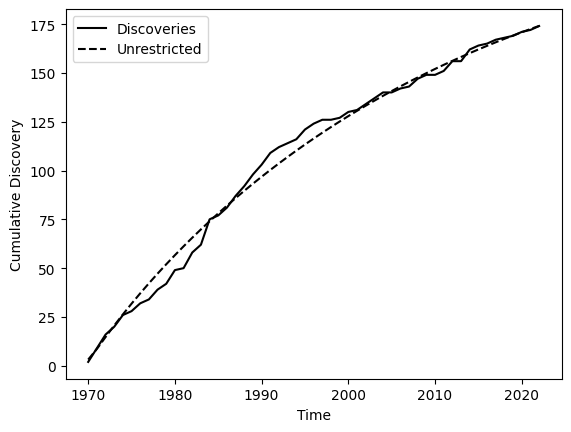

In [48]:
#cube = b3cube.OccurrenceCube("../data/data_PT-30.parquet")
#cube = b3cube.OccurrenceCube("gs://b-cubed-eu/data_PT-30b.parquet", gproject='nithecs-436810')
#cube = b3cube.OccurrenceCube("gs://b-cubed-eu/data_BE.parquet", gproject='nithecs-436810')
cube = b3cube.OccurrenceCube("../data/costa-rica/data_CR_level2.parquet")
#cube = b3cube.OccurrenceCube("/Users/maarten/Downloads/data_AUS_level2.parquet")

cube._species_richness()

#CL, _ = griis.read_checklist("../data/belgium/dwca-unified-checklist-v1.14/")
CL = griis.CheckList("/Users/maarten/Documents/GIT/b3alien/tests/data/costa-rica/dwca-griis-costa-rica-v1.4/merged_distr.txt")

d_s, d_c = b3cube.cumulative_species(cube, CL.species)
#d_s, d_c = b3cube.cumulative_species(cube, CL)

time, rate = b3cube.calculate_rate(d_c)

df = pd.DataFrame({
    "year": time,
    "rate": rate
})

def filter_time_window(df, start_year, end_year):
    """Filter time and rate based on year window."""
    filtered = df[(df["year"] >= start_year) & (df["year"] <= end_year)].reset_index(drop=True)
    return filtered["year"], filtered["rate"]

time, rate = filter_time_window(df, 1970, 2022)

C1, vec1 = simulation.simulate_solow_costello_scipy(time, rate, vis=True)

In [44]:
df

,year,rate
0,1680-01-01,1
1,1700-01-01,3
2,1701-01-01,4
3,1730-01-01,5
5,1792-01-01,10
...,...,...
216,2021-01-01,84
217,2022-01-01,1
218,2023-01-01,-1
4,NaT,-2


In [49]:
b3cube.plot_richness(cube)

In [50]:
print(C1)
print(vec1)

[3.21835324 5.42311011 6.09501982 5.9180348  5.69780835 5.49211097
 5.30097033 5.12366179 4.95902156 4.8056881  4.66227691 4.52748909
 4.40016726 4.27931495 4.16409383 4.0538094  3.94789176 3.84587564
 3.74738182 3.65210079 3.55977894 3.47020719 3.38321177 3.29864681
 3.2163885  3.13633047 3.05838012 2.98245583 2.9084847  2.83640081
 2.76614391 2.69765833 2.6308922  2.56579677 2.50232591 2.44043576
 2.38008438 2.32123155 2.26383851 2.20786789 2.15328352 2.10005036
 2.04813443 1.99750272 1.94812313 1.89996445 1.85299631 1.80718912
 1.76251408 1.71894311 1.67644887 1.63500468 1.59458457]
[ 1.79311589e+00 -2.50163519e-02 -3.97372072e-01  2.34718956e-01
  3.60932145e-01 -1.01641252e-03]


In [ ]:
cum_species

,introDate,total,cumulative_total
0,1680-01-01,1,1
1,1700-01-01,2,3
2,1701-01-01,1,4
3,1730-01-01,1,5
5,1792-01-01,5,10
...,...,...,...
216,2021-01-01,-194,84
217,2022-01-01,-83,1
218,2023-01-01,-2,-1
4,NaT,-1,-2


Bootstrapping: 100%|██████████| 1000/1000 [02:40<00:00,  6.25it/s]


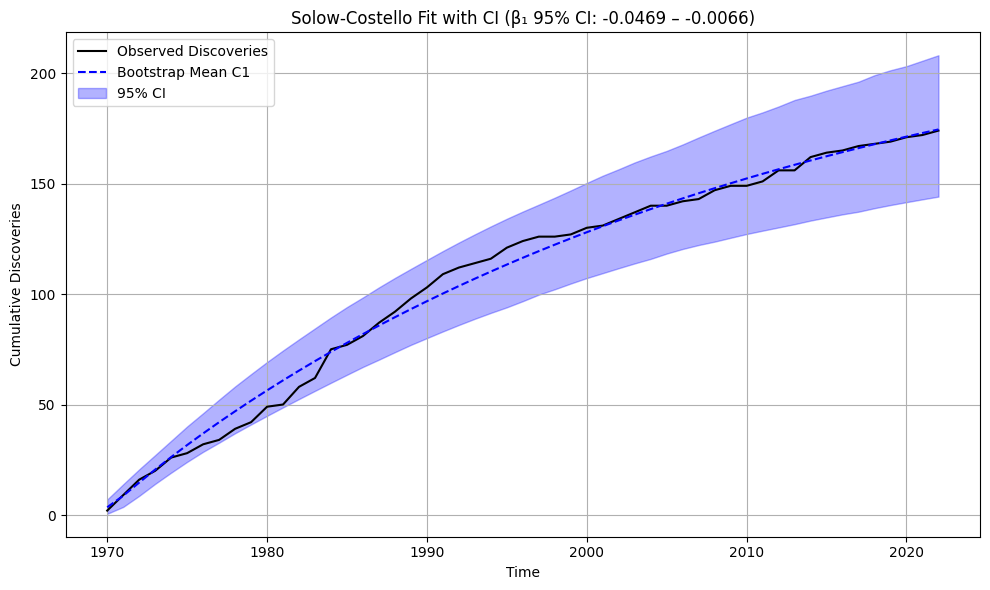

In [51]:
results = simulation.parallel_bootstrap_solow_costello(time, rate, n_iterations=1000)

simulation.plot_with_confidence(time, rate, results)

In [ ]:
print(cube.df.columns)

In [ ]:
print(results)

In [ ]:
gdf = b3cube.aggregate_count_per_cell(cube, "kingdom", "Plantae")

In [ ]:
gdf

In [ ]:
aggregated_gdf_space = gdf.groupby("cellCode").agg({
    "kingdomcount": "sum",
    "geometry": "first"  # assumes geometry is unique per cellCode
}).reset_index()

In [ ]:
aggregated_gdf_time = gdf.groupby("yearmonth").agg({
    "kingdomcount": "sum" # assumes geometry is unique per cellCode
}).reset_index()

In [ ]:
aggregated_gdf_time
aggregated_gdf_time = aggregated_gdf_time[aggregated_gdf_time['yearmonth'].str[:4].astype(int) >= 1677]
aggregated_gdf_time['yearmonth'] = pd.to_datetime(aggregated_gdf_time['yearmonth'], format='%Y-%m')
aggregated_gdf_time['year'] = aggregated_gdf_time['yearmonth'].dt.year

yearly_agg = aggregated_gdf_time.groupby('year')['kingdomcount'].sum().reset_index()
yearly_agg = yearly_agg.sort_values('year')

print(yearly_agg)

def filter_time_window(df, start_year, end_year):
    """Filter time and rate based on year window."""
    filtered = df[(df["year"] >= start_year) & (df["year"] <= end_year)].reset_index(drop=True)
    return filtered["year"], filtered["kingdomcount"]

time, obs = filter_time_window(yearly_agg, 1970, 2022)


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(yearly_agg["year"], yearly_agg["kingdomcount"], marker="o")
plt.title("Obervation effort")
plt.xlabel("Time")
plt.ylabel("Observed Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
survey_eff = b3cube.get_survey_effort(cube, calc_type='distinct')

In [21]:
survey_eff

,date,distinct_observers
0,1900-12-31,192
1,1901-12-31,141
2,1902-12-31,339
3,1903-12-31,140
4,1904-12-31,62
...,...,...
121,2021-12-31,1442624
122,2022-12-31,2028830
123,2023-12-31,2389658
124,2024-12-31,110842


In [53]:
def filter_time_window(df, start_year, end_year):
    """Filter time and rate based on year window."""
    df["date"] = df["date"].dt.year.astype(int)
    filtered = df[(df["date"] >= start_year) & (df["date"] <= end_year)].reset_index(drop=True)
    return filtered["date"], filtered["distinct_observers"]

time2, observ = filter_time_window(survey_eff, 1970, 2022)

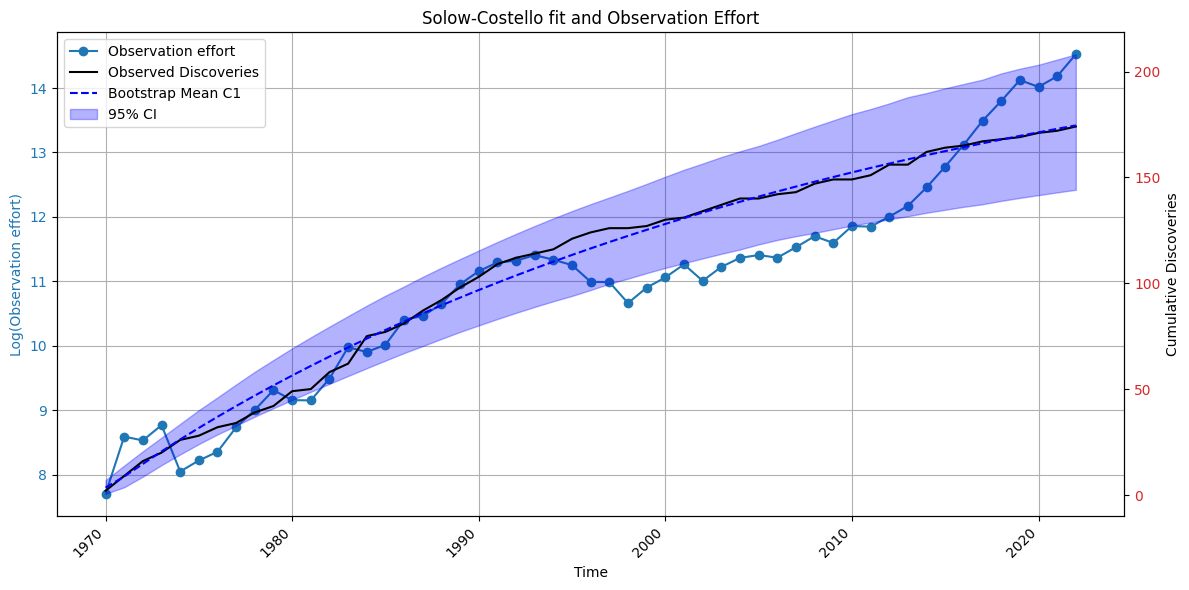

In [54]:
import numpy as np
# Create a figure and the first set of axes (ax1)
# This is the object-oriented way, which is better for complex plots.
fig, ax1 = plt.subplots(figsize=(12, 6))

# --- Plotting the first dataset (left y-axis) ---
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Log(Observation effort)', color=color) # Label for the left y-axis
ax1.plot(time2, np.log(observ), marker='o', linestyle='-', color=color, label='Observation effort')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True) # Add grid lines

# --- Creating and plotting on the second y-axis ---
# Create a second axes that shares the same x-axis
ax2 = ax1.twinx()

color = 'tab:red'
ax2.plot(time, np.cumsum(rate), 'k-', label='Observed Discoveries')
ax2.plot(time, results["c1_mean"], 'b--', label='Bootstrap Mean C1')
ax2.fill_between(time, results["c1_lower"], results["c1_upper"], color='blue', alpha=0.3, label='95% CI')
ax2.set_ylabel('Cumulative Discoveries')
ax2.tick_params(axis='y', labelcolor=color)

# --- Final Touches ---
plt.title('Solow-Costello fit and Observation Effort')
fig.autofmt_xdate(rotation=45) # A better way to handle date rotation

# To create a single legend for both lines
# Get handles and labels from both axes and combine them
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Ensure everything fits without overlapping
fig.tight_layout()

plt.show()

In [ ]:
gdf = gpd.GeoDataFrame(aggregated_gdf_space, geometry="geometry", crs=gdf.crs)

In [ ]:
gdf.crs
gdf["geometry"] = gdf["geometry"].simplify(0.01)
centroid = gdf.geometry.unary_union.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=7)

# Plot
Choropleth(
    geo_data=gdf,
    name='Aggregated',
    data=gdf,
    columns=['cellCode', 'kingdomcount'],
    key_on='feature.properties.cellCode',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Observation effort'
).add_to(m)

folium.LayerControl().add_to(m)

In [ ]:
gdf

In [ ]:
from coldp import COLDP

In [ ]:
coldp = COLDP("../data/costa-rica/297e30b7-5321-44eb-bb2c-26e1d538b4a3")

In [ ]:
print(coldp.names.columns)

In [ ]:
''' 
 # Only execute the following statement if no taxonmatching is performed
griis.do_taxon_matching("../data/costa-rica/dwca-griis-costa-rica-v1.4/")
'''

In [ ]:
display(m)

In [ ]:
cube.df

In [12]:
aggregated_obs_space = cube.df.groupby("cellCode").agg({
    "distinctobservers": "sum",
    "geometry": "first"  # assumes geometry is unique per cellCode
}).reset_index()

/var/folders/x8/_09h8jls5d3fclg4zvtq291c0000gn/T/ipykernel_58822/1800479429.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_obs_space = cube.df.groupby("cellCode").agg({


In [13]:
aggregated_obs_space

,cellCode,distinctobservers,geometry
0,E016S28BB,1954,"POLYGON ((16.75 -28.25, 17 -28.25, 17 -28, 16...."
1,E016S28BC,386,"POLYGON ((16.5 -28.5, 16.75 -28.5, 16.75 -28.2..."
2,E016S28BD,2755,"POLYGON ((16.75 -28.5, 17 -28.5, 17 -28.25, 16..."
3,E016S28CB,5333,"POLYGON ((16.25 -28.75, 16.5 -28.75, 16.5 -28...."
4,E016S28DA,2913,"POLYGON ((16.5 -28.75, 16.75 -28.75, 16.75 -28..."
...,...,...,...
1993,E032S28BA,21232,"POLYGON ((32.5 -28.25, 32.75 -28.25, 32.75 -28..."
1994,E032S28BC,6,"POLYGON ((32.5 -28.5, 32.75 -28.5, 32.75 -28.2..."
1995,E032S28CA,13641,"POLYGON ((32 -28.75, 32.25 -28.75, 32.25 -28.5..."
1996,E032S28CB,7787,"POLYGON ((32.25 -28.75, 32.5 -28.75, 32.5 -28...."


In [14]:
gdf = gpd.GeoDataFrame(aggregated_obs_space, geometry="geometry", crs=cube.df.crs)

In [15]:
gdf.crs
gdf["geometry"] = gdf["geometry"].simplify(0.01)
centroid = gdf.geometry.unary_union.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=7)

# Plot
Choropleth(
    geo_data=gdf,
    name='Aggregated',
    data=gdf,
    columns=['cellCode', 'distinctobservers'],
    key_on='feature.properties.cellCode',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Observation effort'
).add_to(m)

folium.LayerControl().add_to(m)

display(m)

/var/folders/x8/_09h8jls5d3fclg4zvtq291c0000gn/T/ipykernel_58822/2306765869.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.geometry.unary_union.centroid


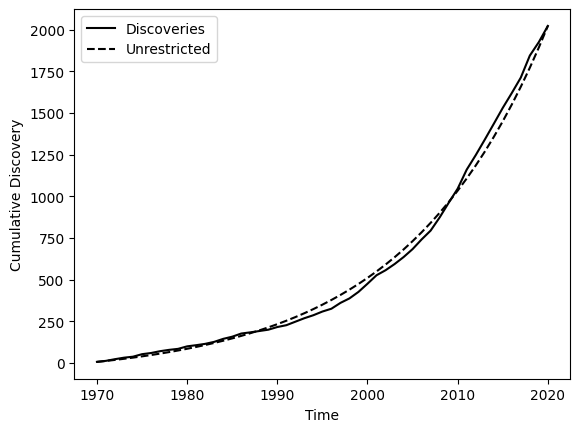

In [55]:
checklist_path = "/Users/maarten/Documents/GIT/b3alien/tests/data/belgium/dwca-unified-checklist-v1.14/"
distribution = checklist_path + "distribution.txt"

df_cl = pd.read_csv(distribution, sep='\t', low_memory=False)

# Specific issue due to the Belgian checklist
df_cl["speciesKey"] = df_cl["id"].str.rsplit("/", n=1).str[-1].astype("int64")

# 1. Filter rows where locality == 'Belgium' and eventDate is not missing
df = df_cl[df_cl["locality"] == "Belgium"].copy()
df = df[df["eventDate"].notna()]

# 2. Split eventDate into intro and outro (assuming 'YYYY/MM' or 'YYYY/MM/YYYY/MM')
def split_event_date(x):
    if isinstance(x, str):
        parts = x.strip().split('/')
        if len(parts) == 2:
            intro = parts[0]
            outro = parts[1]
        else:
            intro = outro = np.nan
        return pd.Series([intro, outro])
    else:
        return pd.Series([np.nan, np.nan])

df[["introDate", "outroDate"]] = df["eventDate"].apply(split_event_date)

df["introDate"] = pd.to_datetime(df["introDate"], format="%Y", errors="coerce")
df["outroDate"] = pd.to_datetime(df["outroDate"], format="%Y", errors="coerce")


# 3. Clean rows with missing introDate
df_intro = df.dropna(subset=["introDate"]).copy()

# 4. Group by introDate and count species
in_species = (
    df_intro.groupby("introDate", sort=True)["id"]
    .count()
    .reset_index(name="nspec")
)

# 5. Cumulative sum
in_species["cumn"] = in_species["nspec"].cumsum()

# 6. Clean outro side and count outgoing species
df_outro = df.dropna(subset=["outroDate"]).copy()

out_species = (
    df_outro.groupby("outroDate", sort=True)["id"]
    .count()
    .reset_index(name="nspeco")
)

# 7. Merge intro and outro on date
n_species = pd.merge(in_species, out_species, how="outer", left_on="introDate", right_on="outroDate")

# 8. Replace NaNs with 0
n_species["nspec"] = n_species["nspec"].fillna(0).astype(int)
n_species["nspeco"] = n_species["nspeco"].fillna(0).astype(int)

# 9. Net species present at each time step
n_species["total"] = n_species["nspec"] - n_species["nspeco"]

# 10. Final frame with total species over time
tot_species = n_species[["introDate", "total"]].copy()

# 11. Optional: sort and compute cumulative total over time
tot_species = tot_species.sort_values("introDate")
tot_species["cumulative_total"] = tot_species["total"].cumsum()

def filter_time_window(df, start_year, end_year):
    """Filter time and rate based on year window."""
    filtered = df[(df["year"] >= start_year) & (df["year"] <= end_year)].reset_index(drop=True)
    return filtered["year"], filtered["rate"]


in_species["time"] = pd.to_datetime(in_species["introDate"])
in_species["cumulative_species"] = in_species["cumn"]

time, rate = b3cube.calculate_rate(in_species)


df = pd.DataFrame({
    "year": time,
    "rate": rate
})

time, rate = filter_time_window(df, 1970, 2020)

C1, vec1 = simulation.simulate_solow_costello_scipy(time, rate, vis=True)

Bootstrapping: 100%|██████████| 200/200 [01:05<00:00,  3.07it/s]


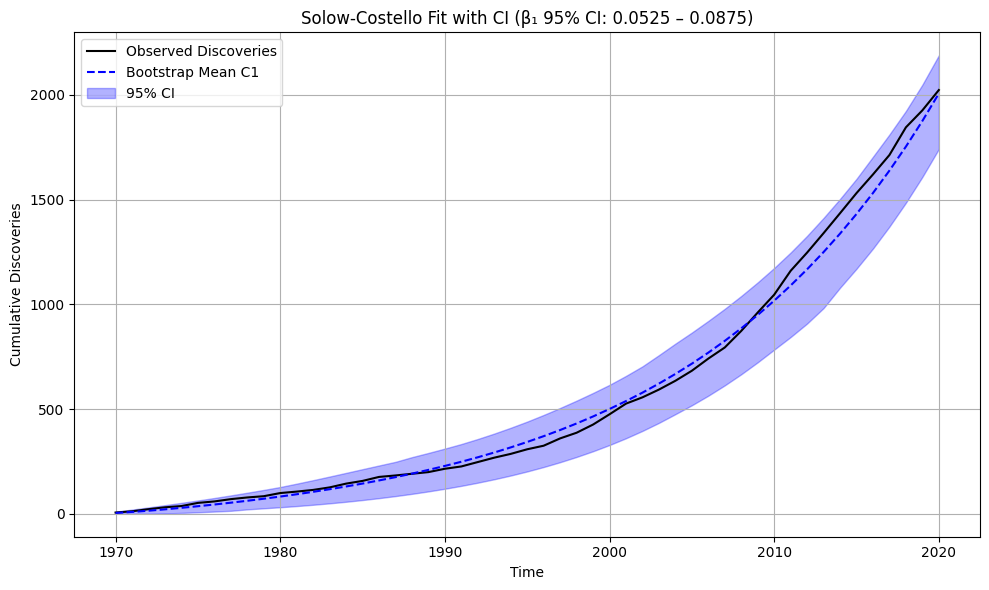

In [57]:
results = simulation.parallel_bootstrap_solow_costello(time, rate, n_iterations=200)

simulation.plot_with_confidence(time, rate, results)

In [56]:
vec1

array([ 1.61125033e+00,  6.37524075e-02,  6.61270176e+01,  7.95788351e-03,
       -1.58332031e+00,  1.89535397e-01])